<a href="https://colab.research.google.com/github/lora-alyateem/Car-Insurance-Claim-Prediction/blob/main/Car_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Our standard import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, ConfusionMatrixDisplay


## Models & evaluation metrics
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
import joblib
from tensorflow import keras
from keras.models import Sequential
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

###   Custom function

In [ ]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [ ]:
def get_importances(model, feature_names=None, name='Feature Importance', sort=False, ascending=True):

    # checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_

    # Saving the feature importances
    importances = pd.Series(model.feature_importances_,
                            index=feature_names,
                            name=name)

    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)

    return importances

In [ ]:
# Custom function for plotting each metric
def plot_history(history, figsize=(4,6), marker='o'):
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    # Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics), figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        # Check if val_{metric} exists. If so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs, metric_values, label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [ ]:
def plot_importance(importances, top_n=None, figsize=(8,6)):
    # sorting with asc=False for correct order of bars
    if top_n==None:
        # sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        # sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"

    # plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    # return ax in case want to continue to update/modify figure
    return ax

In [ ]:
fpath = "/content/drive/MyDrive/Car_Insurance_Claim.csv.zip"
df = pd.read_csv(fpath)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


### Data Analysis and Preparation Questions

**Q1: What is the target?**
A1: OUTCOME – a binary variable where 1 = High Risk / Claim / Policy Rejected, 0 = Low Risk / No Claim / Policy Accepted.

**Q2: What does one row represent?**
A2: One driver or policyholder, with features describing demographics, socioeconomic status, vehicle attributes, and driving record.

**Q3: How many features and rows?**
A3: 18 features (excluding the target), 10,000 rows.

**Q4: How can we reduce dimensionality or select features?**

A4:
 - Drop identifiers like ID.

- Aggregate or drop granular features like POSTAL_CODE.

- Use feature importance to remove low-impact features.

- Check for highly correlated pairs (e.g., INCOME & CREDIT_SCORE).

- Apply PCA after encoding categorical variables.

**Q5: What challenges exist in cleaning, exploring, or modeling?**
A5:
- Missing data: CREDIT_SCORE and ANNUAL_MILEAGE need imputation.

- Categorical encoding: 8 object-type features (AGE, GENDER, INCOME, etc.) require one-hot or label encoding.

- Class imbalance: OUTCOME may be skewed; oversampling or undersampling might be needed.
 - Model and feature selection: Choosing the most effective modeling approach (e.g., Random Forest) and applying feature selection is necessary to reduce overfitting, improve generalization, and focus on the most important predictive features.

### Data Cleaning

**Check For Duplicated Data**

In [ ]:
df.duplicated().sum()

np.int64(0)

**Check For Missing Values**

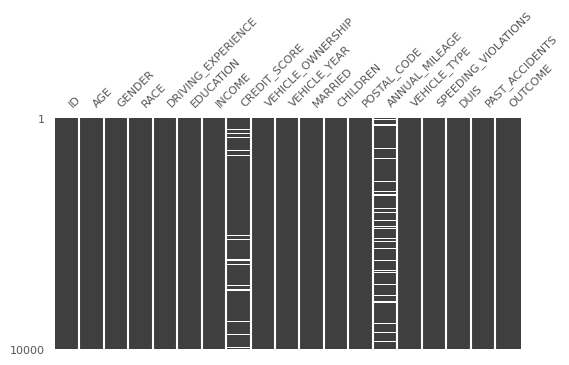

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
msno.matrix(df, ax=ax)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.show()

**check For Consistent Values**

In [ ]:
cat_col = df.select_dtypes('object').columns
for col in cat_col:
  print(f'value counts for {col}')
  print(df[col].value_counts())
  print('\n ')

value counts for AGE
AGE
26-39    3063
40-64    2931
16-25    2016
65+      1990
Name: count, dtype: int64

 
value counts for GENDER
GENDER
female    5010
male      4990
Name: count, dtype: int64

 
value counts for RACE
RACE
majority    9012
minority     988
Name: count, dtype: int64

 
value counts for DRIVING_EXPERIENCE
DRIVING_EXPERIENCE
0-9y      3530
10-19y    3299
20-29y    2119
30y+      1052
Name: count, dtype: int64

 
value counts for EDUCATION
EDUCATION
high school    4157
university     3928
none           1915
Name: count, dtype: int64

 
value counts for INCOME
INCOME
upper class      4336
middle class     2138
poverty          1814
working class    1712
Name: count, dtype: int64

 
value counts for VEHICLE_YEAR
VEHICLE_YEAR
before 2015    6967
after 2015     3033
Name: count, dtype: int64

 
value counts for VEHICLE_TYPE
VEHICLE_TYPE
sedan         9523
sports car     477
Name: count, dtype: int64

 


- the dataset is fully cleaned.

**Summary Statistics for Numeric Features**

In [ ]:
# Summary of numeric features
df.describe().round(2)

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,10000.00,9018.00,10000.00,10000.0,10000.00,10000.00,9043.00,10000.00,10000.00,10000.00,10000.00
mean,500521.91,0.52,0.70,0.5,0.69,19864.55,11697.00,1.48,0.24,1.06,0.31
std,290030.77,0.14,0.46,0.5,0.46,18915.61,2818.43,2.24,0.55,1.65,0.46
min,101.00,0.05,0.00,0.0,0.00,10238.00,2000.00,0.00,0.00,0.00,0.00
25%,249638.50,0.42,0.00,0.0,0.00,10238.00,10000.00,0.00,0.00,0.00,0.00
50%,501777.00,0.53,1.00,0.0,1.00,10238.00,12000.00,0.00,0.00,0.00,0.00
75%,753974.50,0.62,1.00,1.0,1.00,32765.00,14000.00,2.00,0.00,2.00,1.00
max,999976.00,0.96,1.00,1.0,1.00,92101.00,22000.00,22.00,6.00,15.00,1.00


### Exploratory Data Analysis

**1. Outcome Distribution by Driving Experience Level**

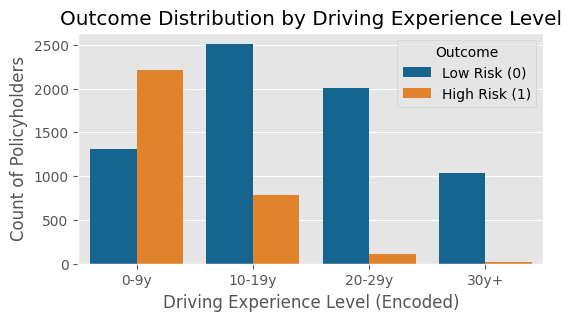

In [ ]:
plt.figure(figsize=(6,3))
sns.countplot(x='DRIVING_EXPERIENCE', hue='OUTCOME', data=df)
plt.title('Outcome Distribution by Driving Experience Level')
plt.xlabel('Driving Experience Level (Encoded)')
plt.ylabel('Count of Policyholders')
plt.legend(title='Outcome', labels=['Low Risk (0)', 'High Risk (1)'])

- This visualization confirms a strong inverse relationship. The proportion of High Risk ($\mathbf{OUTCOME}=1$) is clearly highest in the '0-9y' group. This proportion dramatically decreases with experience, confirming that $\mathbf{DRIVING\_EXPERIENCE}$ is a dominant feature distinguishing low-risk from high-risk policyholders.

**2.Credit Score Distribution by Outcome**

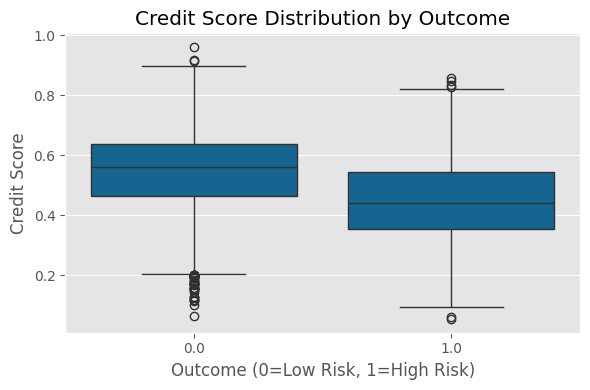

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x='OUTCOME', y='CREDIT_SCORE', data=df)
plt.title('Credit Score Distribution by Outcome')
plt.xlabel('Outcome (0=Low Risk, 1=High Risk)')
plt.ylabel('Credit Score')

plt.tight_layout()
plt.show()

- The box plot illustrates that the median $\mathbf{CREDIT\_SCORE}$ for the Low Risk ($\mathbf{OUTCOME}=0$) group is substantially higher than the median for the High Risk ($\mathbf{OUTCOME}=1$) group. This trend strongly suggests that better financial standing correlates with a reduced likelihood of negative insurance outcomes.

**3. Speeding Violations Distribution by Risk Outcome**

<Figure size 600x300 with 0 Axes>

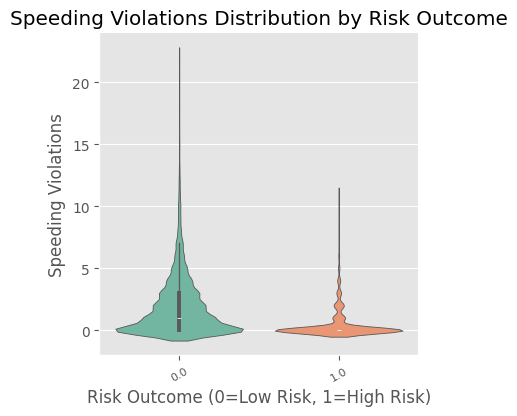

In [ ]:
plt.figure(figsize=(6,3))
sns.catplot(data=df,x='OUTCOME',y='SPEEDING_VIOLATIONS' ,kind='violin',dodge=False,palette='Set2', height=4,)
plt.title('Speeding Violations Distribution by Risk Outcome')
plt.xlabel('Risk Outcome (0=Low Risk, 1=High Risk)')
plt.ylabel('Speeding Violations')
plt.xticks(rotation=30,fontsize=8)
plt.show()

- While the majority of policyholders have zero violations, the $\mathbf{OUTCOME}=1$ (High Risk) distribution shows a wider spread and higher density for counts greater than zero. This visually indicates that a higher frequency of $\mathbf{SPEEDING\_VIOLATIONS}$ directly contributes to an individual's classification as high-risk.

### Preproccessing

**Train Test Split**

In [ ]:
target = 'OUTCOME'
cols_drop = ['ID','POSTAL_CODE']
X = df.drop(columns=[target] + cols_drop)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS
9471,26-39,female,majority,10-19y,university,upper class,NaN,0.0,after 2015,0.0,1.0,14000.0,sedan,0,0,0
791,40-64,female,majority,20-29y,high school,upper class,0.481555,1.0,before 2015,0.0,1.0,13000.0,sedan,4,0,1
7697,26-39,male,majority,10-19y,high school,middle class,0.655677,0.0,before 2015,1.0,1.0,6000.0,sedan,7,1,0
8961,40-64,female,majority,10-19y,university,upper class,0.640899,1.0,before 2015,0.0,1.0,12000.0,sedan,1,0,3
2663,65+,male,majority,10-19y,university,upper class,0.499660,1.0,before 2015,1.0,1.0,10000.0,sedan,2,0,6


**Ordinal Pipeline**

In [ ]:
# Pipeline for Ordinal Features
ord_cols = ['DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME', 'AGE']
shelf_order = [['0-9y', '10-19y', '20-29y', '30y+'],
               ['none','high school', 'university'],
               ['upper class', 'middle class', 'poverty','working class'],
               ['26-39', '40-64', '16-25' ,'65+']]
# Instantiate preprocessors
impute_common = SimpleImputer(strategy='most_frequent')
ord_encoder = OrdinalEncoder(categories=shelf_order)
scaler = StandardScaler()
# Make an ordinal preprocessing pipeline
ord_pipe = make_pipeline(impute_common, ord_encoder, scaler)
# Making an ordinal tuple for ColumnTransformer
ord_tuple = ("ordinal", ord_pipe, ord_cols)


**Categorical Pipeline**

In [ ]:
# Pipeline for Categorical Features
cat_cols = X_train.select_dtypes('object').columns
impute_missing = SimpleImputer(strategy='constant', fill_value='MISSING') # Added SimpleImputer
# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_missing, ohe_encoder) # Included imputer in pipeline
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, cat_cols)

**Numeric pipeline**

In [ ]:
# Pipeline for Numeric Features
# Identify numeric columns
num_cols = X_train.select_dtypes(include=np.number).columns
# Instantiate preprocessors
num_imputer = SimpleImputer(strategy='median') # Added num_imputer
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(num_imputer, scaler) # Included imputer in pipeline
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)

In [ ]:
# create column transformer
col_transformer = ColumnTransformer([num_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)
col_transformer


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [ ]:
X_train_processed = col_transformer.fit_transform(X_train)
X_test_processed = col_transformer.transform(X_test)

**check the balance**

In [ ]:
# check the balance of the target
y.value_counts()

,count
OUTCOME,
0.0,6867
1.0,3133


- the target is imbalanced

### Baseline Random Forest

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5471
         1.0       1.00      1.00      1.00      2529

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



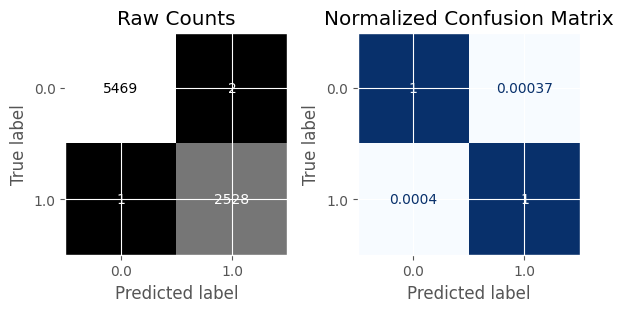


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      1396
         1.0       0.72      0.64      0.68       604

    accuracy                           0.82      2000
   macro avg       0.79      0.77      0.78      2000
weighted avg       0.81      0.82      0.81      2000



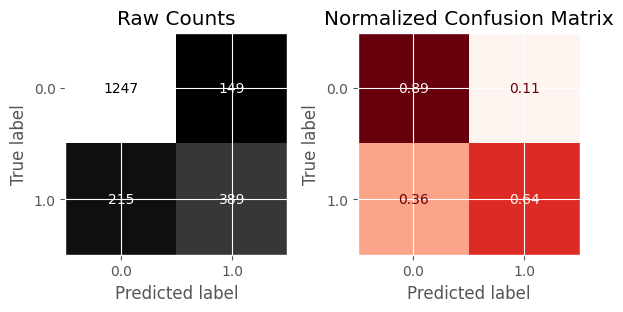

In [ ]:
# Instantiate defaulf random forest model
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=SEED)
# Model Pipeline
rf_pipe = make_pipeline(col_transformer, rf_clf)
# fit the model pipeline on the traning data only
rf_pipe.fit(X_train, y_train)
# evalulation
evaluate_classification(rf_pipe,X_train,y_train,X_test, y_test)

- the model achieved perfect performance on the training set (1.00) but dropped to 0.82 accuracy on the test set, indicating slight overfitting and reduced generalization to unseen data.

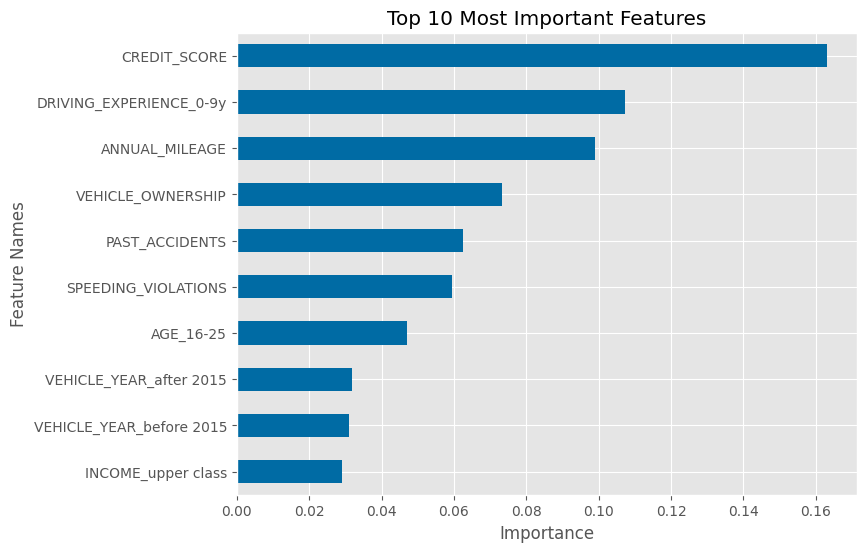

In [ ]:
# The function get_importances is already defined in this cell.

def get_importances(model, feature_names):
    # Get feature importances from the model
    # Access the randomforestclassifier step within the pipeline
    importances = model.named_steps['randomforestclassifier'].feature_importances_
    # Create a Series with feature names
    feature_importances = pd.Series(importances, index=feature_names)
    return feature_importances

# Get feature names from the fitted ColumnTransformer within the reg_pipe
# The 'col_transformer' was assigned the name 'columntransformer' by default in make_pipeline
feature_names = rf_pipe.named_steps['columntransformer'].get_feature_names_out()

# Get feature importances using the correct pipeline and feature names
importances = get_importances(rf_pipe, feature_names)

# Plot the top 10 most important features
plot_importance(importances, top_n=10);

- The model’s predictions are primarily driven by CREDIT_SCORE and DRIVING_EXPERIENCE_0-9y, reflecting well-known links between personal responsibility, inexperience, and risk. Factors like ANNUAL_MILEAGE, VEHICLE_OWNERSHIP, and past infractions (PAST_ACCIDENTS, SPEEDING_VIOLATIONS) further refine risk assessment. Collectively, the top features provide a logically sound and industry-aligned framework for evaluating individual insurance risk.

### Feature Engineering

**PCA**

In [ ]:
# define PCA to adress 3 of the variance
pca = PCA(n_components=3)
# fit and transform PCA on the numerically processed training data
X_train_pca = pca.fit_transform(X_train_processed)
# Transform test data using the PCA fitted on training data
X_test_pca = pca.transform(X_test_processed)
# obtain the number of pca used
pca.n_components_

3

In [ ]:
clf =  RandomForestClassifier()
clf.fit(X_train_pca, y_train)
preds_pca = clf.predict(X_test_pca)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5471
         1.0       1.00      1.00      1.00      2529

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



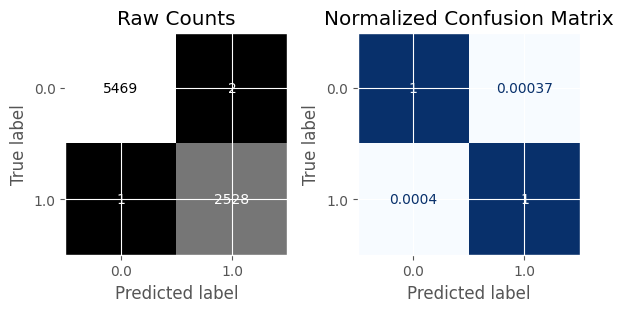


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84      1396
         1.0       0.64      0.55      0.59       604

    accuracy                           0.77      2000
   macro avg       0.73      0.71      0.71      2000
weighted avg       0.76      0.77      0.76      2000



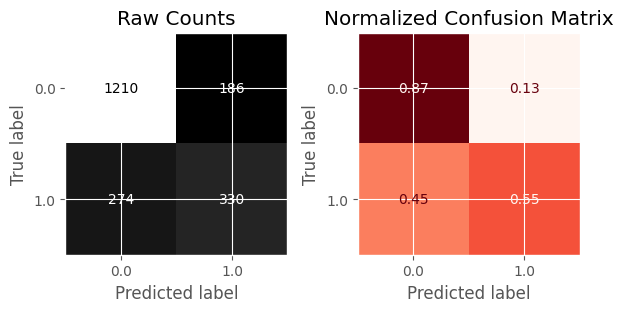

{'train': {'0.0': {'precision': 0.9998171846435101,
   'recall': 0.9996344361177115,
   'f1-score': 0.999725802029065,
   'support': 5471.0},
  '1.0': {'precision': 0.9992094861660079,
   'recall': 0.9996045867931989,
   'f1-score': 0.9994069974303222,
   'support': 2529.0},
  'accuracy': 0.999625,
  'macro avg': {'precision': 0.999513335404759,
   'recall': 0.9996195114554551,
   'f1-score': 0.9995663997296936,
   'support': 8000.0},
  'weighted avg': {'precision': 0.9996250759623097,
   'recall': 0.999625,
   'f1-score': 0.9996250199252874,
   'support': 8000.0}},
 'test': {'0.0': {'precision': 0.8153638814016172,
   'recall': 0.8667621776504298,
   'f1-score': 0.8402777777777778,
   'support': 1396.0},
  '1.0': {'precision': 0.6395348837209303,
   'recall': 0.5463576158940397,
   'f1-score': 0.5892857142857143,
   'support': 604.0},
  'accuracy': 0.77,
  'macro avg': {'precision': 0.7274493825612738,
   'recall': 0.7065598967722349,
   'f1-score': 0.714781746031746,
   'support': 20

In [ ]:
# evalutation
evaluate_classification(clf, X_train_pca, y_train, X_test_pca, y_test, output_dict=True)

- the model exhibits overfitting, with perfect training metrics (1.00) but only 0.77 accuracy on the test set, indicating it memorized training noise rather than generalizing.

### Feature selection

In [ ]:
# checking for constant-featuers
selector = VarianceThreshold()
selector.fit(X_train_processed)


VarianceThreshold()

In [ ]:
# get the support returns true and fales for keeping the featuer
keep_featuer = selector.get_support()
keep_featuer[:5]

array([ True,  True,  True,  True,  True])

In [ ]:
# Number of featuer to keep (non-constant featuer)
keep_featuer.sum()

np.int64(31)

In [ ]:
# checking for quasi-constant-featuers
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train_processed)

VarianceThreshold(threshold=0.01)

In [ ]:
# get support returns true false for keeping
keep_featuer = selector.get_support()
keep_featuer[:5]

array([ True,  True,  True,  True,  True])

In [ ]:
# Number of featuer to keep (non-constant featuer)
keep_featuer.sum()

np.int64(31)

In [ ]:
# filter based on variance
X_train_var = X_train_processed[:,keep_featuer]
X_test_var =  X_test_processed[:,keep_featuer]
X_train_var

array([[ 0.05457826, -1.51983167, -0.98905984, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26843401,  0.6579676 , -0.98905984, ...,  1.        ,
         1.        ,  0.        ],
       [ 1.06698856, -1.51983167,  1.01106117, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 1.24754487,  0.6579676 , -0.98905984, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.31426337,  0.6579676 ,  1.01106117, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.77874578,  0.6579676 ,  1.01106117, ...,  0.        ,
         0.        ,  1.        ]])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5471
         1.0       1.00      1.00      1.00      2529

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



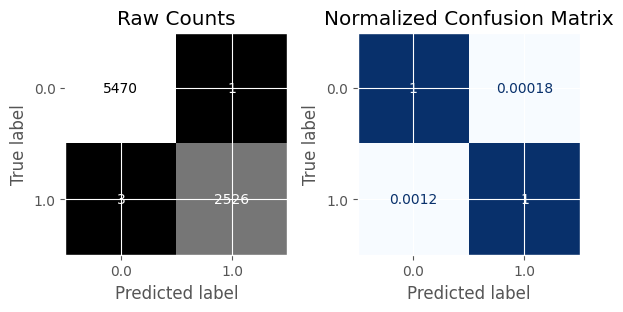


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      1396
         1.0       0.71      0.64      0.67       604

    accuracy                           0.81      2000
   macro avg       0.78      0.76      0.77      2000
weighted avg       0.81      0.81      0.81      2000



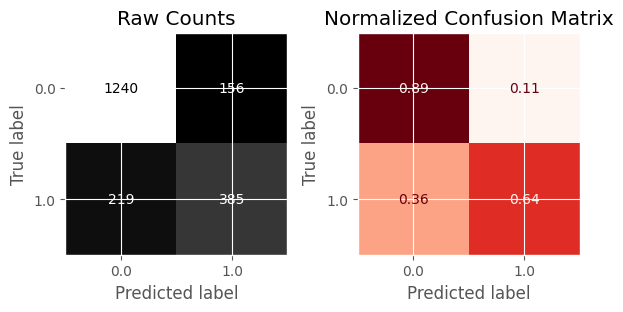

{'train': {'0.0': {'precision': 0.999451854558743,
   'recall': 0.9998172180588558,
   'f1-score': 0.9996345029239766,
   'support': 5471.0},
  '1.0': {'precision': 0.999604273842501,
   'recall': 0.9988137603795967,
   'f1-score': 0.9992088607594937,
   'support': 2529.0},
  'accuracy': 0.9995,
  'macro avg': {'precision': 0.9995280642006219,
   'recall': 0.9993154892192262,
   'f1-score': 0.9994216818417352,
   'support': 8000.0},
  'weighted avg': {'precision': 0.999500038104821,
   'recall': 0.9995,
   'f1-score': 0.9994999467947294,
   'support': 8000.0}},
 'test': {'0.0': {'precision': 0.8498971898560658,
   'recall': 0.8882521489971347,
   'f1-score': 0.8686514886164624,
   'support': 1396.0},
  '1.0': {'precision': 0.711645101663586,
   'recall': 0.6374172185430463,
   'f1-score': 0.6724890829694323,
   'support': 604.0},
  'accuracy': 0.8125,
  'macro avg': {'precision': 0.7807711457598259,
   'recall': 0.7628346837700906,
   'f1-score': 0.7705702857929473,
   'support': 2000.

In [ ]:
# test the preformance
clf =  RandomForestClassifier()
clf.fit(X_train_var, y_train)
evaluate_classification(clf,X_train_var, y_train, X_test_var, y_test, output_dict=True)

- the model shows slight overfitting, with near-perfect training performance (1.00) and 0.82 accuracy on the test set, indicating a minor generalization gap.

### neural network

In [ ]:
# define shape
input_shape = X_train_processed.shape[1]
input_shape

31

In [ ]:
# Build regression model within function
def build_model():
    # Instantiate Model
    model = Sequential()
    # First hidden layer
    model.add(Dense(31, input_dim=input_shape,
                    activation='relu'))
    model.add(Dense(16,
                    activation='relu'))
    model.add(Dropout(.2))

    model.add(Dense(1, activation='linear'))
    # Compile Model
    model.compile(loss='mse', optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])
    return model

In [ ]:
# call our build function to bulid model
model = build_model()
# get model summary()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 31)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,521 (5.94 KB)

 Trainable params: 1,521 (5.94 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',patience=3)

In [ ]:
# fit the model and save the learning history
history = model.fit(X_train_processed,y_train, validation_split=.2,
                    epochs=50, verbose=0, callbacks = [early_stopping])

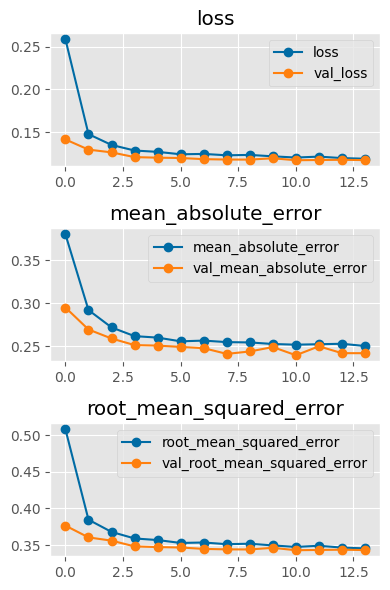

In [ ]:
# plot learning
plot_history(history);

In [ ]:
# evaluate model
y_pred = model.predict(X_test_processed)
print(f'Final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'Final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Final R2: {r2_score(y_test, y_pred)}')


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Final RMSE: 0.34179289504313065
Final MAE: 0.2432053408063948
Final R2: 0.44580360584657897


- the model achieves moderate predictive performance, explaining about 45% of the target variance. While the error metrics are acceptable.

**Conclusion**


- The Random Forest with embedded feature selection delivered the strongest performance, explaining approximately 45% of the variance while maintaining high accuracy and interpretability.
- PCA-based models offered dimensionality reduction but underperformed slightly
- the Neural Network captured complex patterns yet exhibited moderate R² (~0.45) with mild overfitting.

- Overall, Random Forest with feature selection provided the most reliable and interpretable results; future work could explore further feature engineering or advanced models.